In [2]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.functional as F
import torch.nn.functional as F
import plotly.express as px
import pandas as pd
import pymorphy2
from torch import nn
from unicodedata import normalize
from matplotlib import pyplot as plt
import plotly.graph_objects as go

In [1]:
!pip install pymorphy2

In [3]:
import regex as re
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
morph = pymorphy2.MorphAnalyzer()

def remove_punctuation(text):
    return re.sub(r"\p{P}+", "", text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df = pd.read_excel('./sample_data/culture_contents.xlsx')
df.head()

,url,title,text,topic,tags,date
0,https://lenta.ru/news/2008/04/25/snipes/,Уэсли Снайпса приговорили к трем годам тюрьмы,Американского актера Уэсли Снайпса в четверг п...,Культура,Кино,2008/04/25
1,https://lenta.ru/news/2013/01/14/mendes/,"Режиссер последнего ""Бонда"" займется сериалом ...","Режиссер Сэм Мендес, снявший ""007: Координаты ...",Культура,Кино,2013/01/14
2,https://lenta.ru/news/2013/01/14/mcafee/,Жизнь Джона Макафи экранизируют,Кинокомпания Warner Bros. снимет фильм о жизни...,Культура,Кино,2013/01/14
3,https://lenta.ru/news/2013/01/14/kylie/,СМИ сообщили об уходе Кайли Миноуг из музыки в...,Австралийская певица Кайли Миноуг решила покин...,Культура,Кино,2013/01/14
4,https://lenta.ru/news/2013/01/14/aboutaboy/,"""Мой мальчик"" по Нику Хорнби станет сериалом",Телеканал NBC заказал съемки пилотного эпизода...,Культура,Кино,2013/01/14


In [28]:
corpus = list(df['title'][:100].apply(lambda x: "".join(filter(lambda x: not x.isdigit(), remove_punctuation(normalize('NFKD', x)))))) 

In [29]:

def tokenize_corpus(corpus):
    normal = [list(map(lambda normal: morph.parse(normal)[0].normal_form, x.split())) for x in corpus]
    tokens = [[token for token in x if token not in stopwords.words("russian")] for x in normal]
    return tokens

tokenized_corpus = tokenize_corpus(corpus)

In [30]:
tokenized_corpus

[['уэсли', 'снайпёс', 'приговорить', 'год', 'тюрьма'],
 ['режиссёр',
  'последний',
  'бонд',
  'зайаться',
  'сериал',
  'дракула',
  'франкенштейич'],
 ['жизнь', 'джон', 'макафи', 'экранизировать'],
 ['сми', 'сообщить', 'уход', 'кайть', 'миноуга', 'музыка', 'кино'],
 ['мой', 'мальчик', 'ник', 'хорнби', 'стать', 'сериал'],
 ['cоздатель', 'тюдор', 'сделать', 'сериал', 'александр', 'македонский'],
 ['главный',
  'героиня',
  'секс',
  'большой',
  'город',
  'встретиться',
  'дневник',
  'кэрри'],
 ['пират', 'карибский', 'море', 'получить', 'сценарист'],
 ['мозг', 'чарли', 'шина', 'вскрыть', 'новый', 'трейлера'],
 ['спилберг', 'зайаться', 'парк', 'юрский', 'период'],
 ['тело', 'актриса', 'натали', 'вуд', 'наслать', 'ушиб'],
 ['создатель', 'южный', 'парк', 'основать', 'свой', 'киностудия'],
 ['создателей',
  'хоббит',
  'попросить',
  'вернуть',
  'деньга',
  'новозеландский',
  'налогоплательщик'],
 ['энн', 'хэтэуэй', 'сыграть', 'укрощение', 'строптивой'],
 ['умереть', 'режисс

In [31]:
vocabulary = []
for sentence in tokenized_corpus:
    for token in sentence:
        if token not in vocabulary:
            vocabulary.append(token)

word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}

vocabulary_size = len(vocabulary)

In [ ]:
word2idx

In [32]:
vocabulary_size

416

In [33]:
window_size = 2
idx_pairs = []
# for each sentence
for sentence in tokenized_corpus:
    indices = [word2idx[word] for word in sentence]
    # for each word, threated as center word
    for center_word_pos in range(len(indices)):
        # for each window position
        for w in range(-window_size, window_size + 1):
            context_word_pos = center_word_pos + w
            # make soure not jump out sentence
            if context_word_pos < 0 or context_word_pos >= len(indices) or center_word_pos == context_word_pos:
                continue
            context_word_idx = indices[context_word_pos]
            idx_pairs.append((indices[center_word_pos], context_word_idx))

idx_pairs = np.array(idx_pairs) # it will be useful to have this as numpy array

In [34]:
idx_pairs[:10]

array([[0, 1],
       [0, 2],
       [1, 0],
       [1, 2],
       [1, 3],
       [2, 0],
       [2, 1],
       [2, 3],
       [2, 4],
       [3, 1]])

In [35]:
def get_input_layer(word_idx):
    x = torch.zeros(vocabulary_size).float()
    x[word_idx] = 1.0
    return x

In [36]:
D_in, H, D_out = vocabulary_size, 5, vocabulary_size
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.f_lin = nn.Linear(D_in, H)
        self.s_lin = nn.Linear(H, D_out)
        
    def forward(self, X):
        X = self.f_lin(X)
        return F.log_softmax(self.s_lin(X), dim=0)
    
model = MyModule()
loss_fn = nn.NLLLoss()
optim = torch.optim.Adam(model.parameters(), 0.001)

Loss at epo 0: 6.208875377500991
Loss at epo 1: 5.980740903675414
Loss at epo 2: 5.8626254123067065
Loss at epo 3: 5.737239625703127
Loss at epo 4: 5.651492576134743
Loss at epo 5: 5.571016880508839
Loss at epo 6: 5.488009812571374
Loss at epo 7: 5.400886045428183
Loss at epo 8: 5.309937845074932
Loss at epo 9: 5.215737693029458
Loss at epo 10: 5.119686472019503
Loss at epo 11: 5.024716884959622
Loss at epo 12: 4.932985597438314
Loss at epo 13: 4.844894389217087
Loss at epo 14: 4.760124613086288
Loss at epo 15: 4.678442552791922
Loss at epo 16: 4.599769308561384
Loss at epo 17: 4.524075586623081
Loss at epo 18: 4.451292154801713
Loss at epo 19: 4.381382876400993
Loss at epo 20: 4.314290345352223
Loss at epo 21: 4.24997687084941
Loss at epo 22: 4.188331855943254
Loss at epo 23: 4.129270601265504
Loss at epo 24: 4.072691463305661
Loss at epo 25: 4.018495541959647
Loss at epo 26: 3.966596899257703
Loss at epo 27: 3.916887724803066
Loss at epo 28: 3.8692868637217477
Loss at epo 29: 3.82368

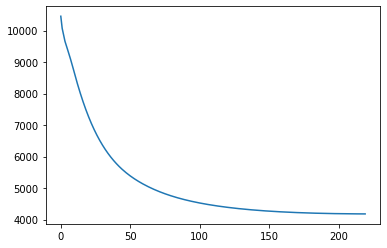

In [37]:
losses = []
for epo in range(220):
    loss_val = 0
    for data, target in idx_pairs:
        X = Variable(get_input_layer(data)).float()
    # forward
        y_pred = model(X)
        y_true = Variable(torch.from_numpy(np.array([target])).long())
    # loss
        loss = loss_fn(y_pred.view(1,-1), y_true)
        loss_val += loss.data.item()
        optim.zero_grad()
        loss.backward()
        optim.step()
    losses.append(loss_val)
    print(f'Loss at epo {epo}: {loss_val/len(idx_pairs)}')
plt.plot(losses)

In [57]:
inputText = "премия"
input = Variable(get_input_layer(word2idx[inputText])).float()
output = model(input)
result = [(idx2word[idx], w.data.item()) for (idx, w) in enumerate(output)]
result.sort(key=lambda tup: tup[1], reverse=True)
df = pd.DataFrame(np.arange(0, 30), columns=['names'])
df['probs'] = list(map(lambda x: x[1], result[:30]))
df['names'] = list(map(lambda x: x[0], result[:30]))

min = abs(df["probs"].min())
df['probs'] = df['probs'].apply(lambda x: ((min - abs(x)) / min) * 100)
fig = px.bar(df, x='names', y='probs',
             hover_data=['names', 'probs'], 
             labels= {'names':'Слово', 'probs': 'Вероятность'}, 
             color='probs', height=500, title = 'Соседние слова для слова ' + inputText)
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.show()

In [61]:
x = np.arange(0, len(losses))
fig = go.Figure(data=go.Scatter(x=x, y=losses, line=dict(color="#8A2BE2")))
fig.show()